**Import Libraries**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier


In [4]:
import kagglehub

path = kagglehub.dataset_download("amulyas/penguin-size-dataset")
print("Dataset folder:", path)

df = pd.read_csv(os.path.join(path, "penguins_size.csv"))
df.head()

Dataset folder: C:\Users\KIIT0001\.cache\kagglehub\datasets\amulyas\penguin-size-dataset\versions\1


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [5]:
num_cols = ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

df["sex"] = df["sex"].fillna(df["sex"].mode()[0])

print("Missing values after filling:\n", df.isnull().sum())


Missing values after filling:
 species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


In [6]:
X = df.drop("species", axis=1)
y = df["species"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (344, 6)
y shape: (344,)


In [8]:
X = pd.get_dummies(X, drop_first=True)
print("Encoded X shape:", X.shape)
X.head()

Encoded X shape: (344, 8)


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,39.10,18.7,181.0,3750.0,False,True,False,True
1,39.50,17.4,186.0,3800.0,False,True,True,False
2,40.30,18.0,195.0,3250.0,False,True,True,False
3,44.45,17.3,197.0,4050.0,False,True,False,True
4,36.70,19.3,193.0,3450.0,False,True,True,False


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)

Train: (275, 8)
Test : (69, 8)


In [27]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [28]:
dt_pred = dt.predict(X_test)

In [29]:
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print("\nDecision Tree Confusion Matrix:\n", confusion_matrix(y_test, dt_pred))
print("\nDecision Tree Classification Report:\n", classification_report(y_test, dt_pred))

Decision Tree Accuracy: 0.9855072463768116

Decision Tree Confusion Matrix:
 [[29  0  1]
 [ 0 14  0]
 [ 0  0 25]]

Decision Tree Classification Report:
               precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       0.96      1.00      0.98        25

    accuracy                           0.99        69
   macro avg       0.99      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



In [10]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Baseline Accuracy: 0.9855072463768116

Confusion Matrix:
 [[29  1  0]
 [ 0 14  0]
 [ 0  0 25]]

Classification Report:
               precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        30
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           0.99        69
   macro avg       0.98      0.99      0.98        69
weighted avg       0.99      0.99      0.99        69



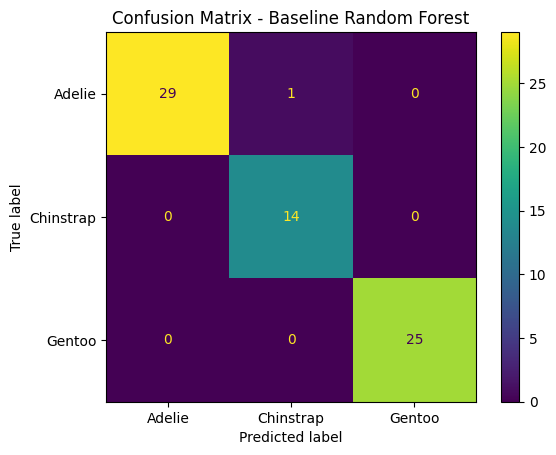

In [11]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Confusion Matrix - Baseline Random Forest")
plt.show()

In [12]:
tree_values = [10, 50, 100, 200, 300]
acc_list = []

for n in tree_values:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    acc_list.append(acc)
    print(f"Trees = {n} -> Accuracy = {acc:.4f}")

best_n = tree_values[np.argmax(acc_list)]
print("\nBest n_estimators:", best_n)

Trees = 10 -> Accuracy = 0.9710
Trees = 50 -> Accuracy = 0.9855
Trees = 100 -> Accuracy = 0.9855
Trees = 200 -> Accuracy = 1.0000
Trees = 300 -> Accuracy = 1.0000

Best n_estimators: 200


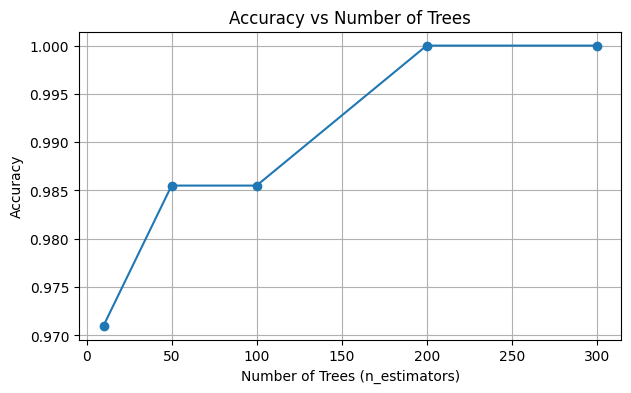

In [13]:
plt.figure(figsize=(7,4))
plt.plot(tree_values, acc_list, marker="o")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Trees")
plt.grid(True)
plt.show()

In [14]:
depth_values = [3, 5, 7, 10, None]
best_acc = 0
best_depth = None

for d in depth_values:
    model = RandomForestClassifier(
        n_estimators=best_n,
        max_depth=d,
        random_state=42
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)

    print(f"Depth = {d} -> Accuracy = {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_depth = d

print("\nBest max_depth:", best_depth)
print("Best Accuracy:", best_acc)

Depth = 3 -> Accuracy = 0.9855
Depth = 5 -> Accuracy = 1.0000
Depth = 7 -> Accuracy = 1.0000
Depth = 10 -> Accuracy = 0.9855
Depth = None -> Accuracy = 1.0000

Best max_depth: 5
Best Accuracy: 1.0


In [15]:
final_rf = RandomForestClassifier(
    n_estimators=best_n,
    max_depth=best_depth,
    random_state=42
)

final_rf.fit(X_train, y_train)
final_pred = final_rf.predict(X_test)

print(" Final Accuracy:", accuracy_score(y_test, final_pred))
print("\n Final Confusion Matrix:\n", confusion_matrix(y_test, final_pred))
print("\n Final Classification Report:\n", classification_report(y_test, final_pred))


 Final Accuracy: 1.0

 Final Confusion Matrix:
 [[30  0  0]
 [ 0 14  0]
 [ 0  0 25]]

 Final Classification Report:
               precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



In [17]:
cv_scores = cross_val_score(final_rf, X, y, cv=5)
print("CV Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

CV Scores: [1.         0.98550725 0.98550725 0.98550725 0.98529412]
Mean CV Accuracy: 0.9883631713554987


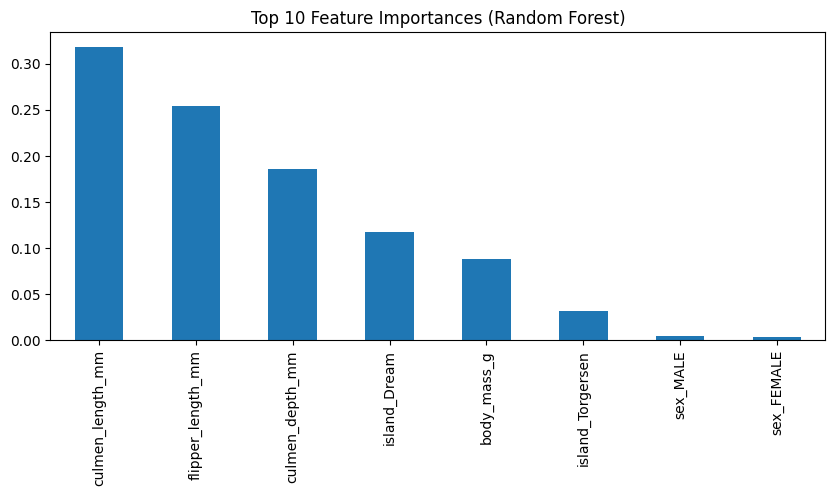


Full Feature Importance List:
 culmen_length_mm     0.318339
flipper_length_mm    0.254007
culmen_depth_mm      0.185361
island_Dream         0.116711
body_mass_g          0.087441
island_Torgersen     0.031146
sex_MALE             0.004015
sex_FEMALE           0.002979
dtype: float64


In [18]:
import pandas as pd

imp = pd.Series(final_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,4))
imp.head(10).plot(kind="bar")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

print("\nFull Feature Importance List:\n", imp)

Total trees in forest: 200


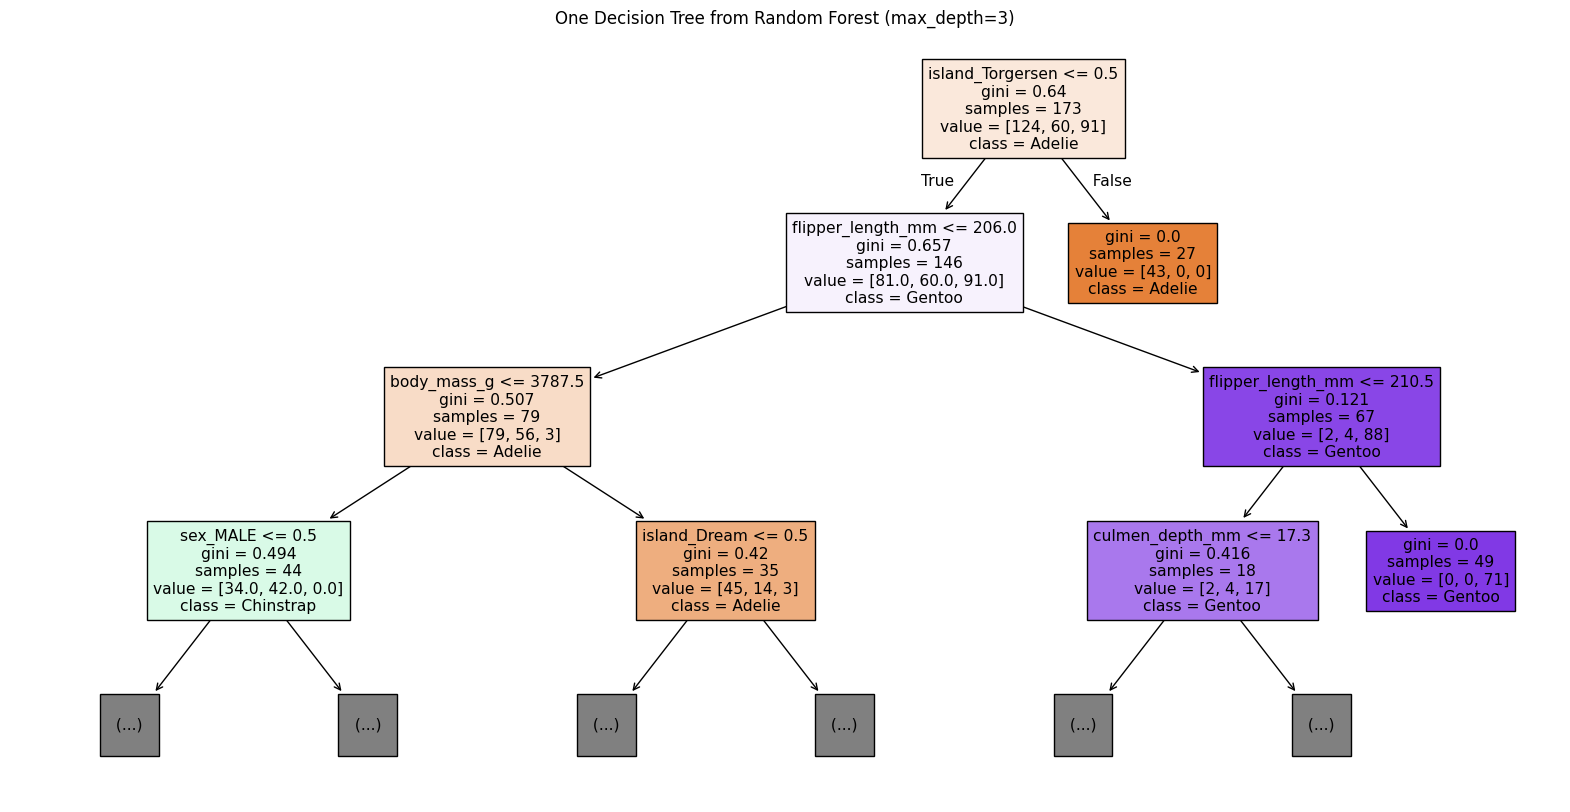

In [45]:
from sklearn.tree import plot_tree

print("Total trees in forest:", len(final_rf.estimators_))

plt.figure(figsize=(20,10))
plot_tree(
    final_rf.estimators_[0],
    feature_names=X.columns,
    class_names=final_rf.classes_,
    filled=True,
    max_depth=3
)
plt.title("One Decision Tree from Random Forest (max_depth=3)")
plt.show()


In [22]:
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10]
}

In [23]:
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='accuracy')

In [24]:
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best CV Score: 0.989090909090909


In [25]:
best_model = grid.best_estimator_
best_pred = best_model.predict(X_test)

print("Best Model Test Accuracy:", accuracy_score(y_test, best_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, best_pred))
print("\nClassification Report:\n", classification_report(y_test, best_pred))

Best Model Test Accuracy: 0.9710144927536232

Confusion Matrix:
 [[28  1  1]
 [ 0 14  0]
 [ 0  0 25]]

Classification Report:
               precision    recall  f1-score   support

      Adelie       1.00      0.93      0.97        30
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       0.96      1.00      0.98        25

    accuracy                           0.97        69
   macro avg       0.96      0.98      0.97        69
weighted avg       0.97      0.97      0.97        69



In [31]:
dt_acc = accuracy_score(y_test, dt_pred)

In [32]:
# Random Forest baseline results
rf_acc = accuracy_score(y_test, y_pred)

In [33]:
# Manual tuned RF results
final_acc = accuracy_score(y_test, final_pred)

In [34]:
best_model = grid.best_estimator_
best_pred = best_model.predict(X_test)
grid_acc = accuracy_score(y_test, best_pred)

In [35]:
print("Decision Tree Accuracy      :", dt_acc)
print("Random Forest Baseline Acc  :", rf_acc)
print("Manual Tuned RF Accuracy    :", final_acc)
print("GridSearch Tuned RF Accuracy:", grid_acc)

Decision Tree Accuracy      : 0.9855072463768116
Random Forest Baseline Acc  : 0.9855072463768116
Manual Tuned RF Accuracy    : 1.0
GridSearch Tuned RF Accuracy: 0.9710144927536232


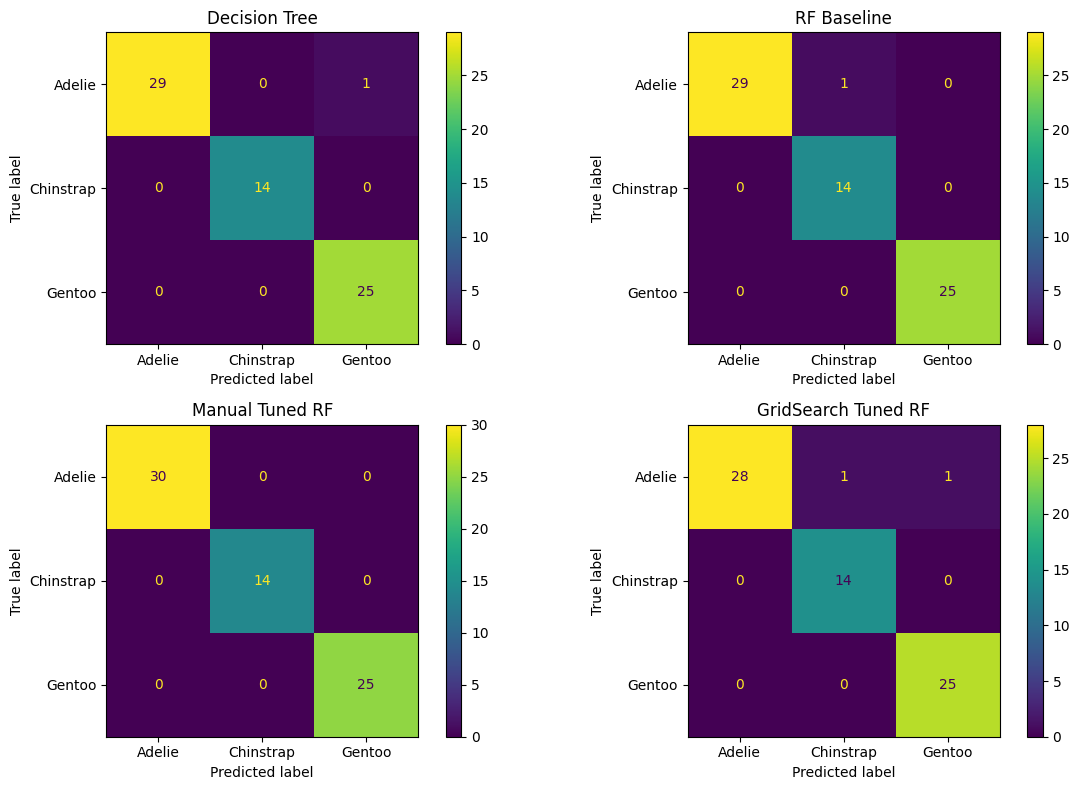

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

ConfusionMatrixDisplay.from_predictions(y_test, dt_pred, ax=axes[0,0])
axes[0,0].set_title("Decision Tree")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0,1])
axes[0,1].set_title("RF Baseline")

ConfusionMatrixDisplay.from_predictions(y_test, final_pred, ax=axes[1,0])
axes[1,0].set_title("Manual Tuned RF")

ConfusionMatrixDisplay.from_predictions(y_test, best_pred, ax=axes[1,1])
axes[1,1].set_title("GridSearch Tuned RF")

plt.tight_layout()
plt.show()

In [38]:
print("    Decision Tree Report\n")
print(classification_report(y_test, dt_pred))

print("\n     Random Forest Baseline Report \n")
print(classification_report(y_test, y_pred))

print("\n    Manual Tuned RF Report \n")
print(classification_report(y_test, final_pred))

print("\n     GridSearch Tuned RF Report \n")
print(classification_report(y_test, best_pred))


    Decision Tree Report

              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       0.96      1.00      0.98        25

    accuracy                           0.99        69
   macro avg       0.99      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69


     Random Forest Baseline Report 

              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        30
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           0.99        69
   macro avg       0.98      0.99      0.98        69
weighted avg       0.99      0.99      0.99        69


    Manual Tuned RF Report 

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00  